# バックテスト分析：長期的なリターンの推移

2014年から2023年までのデータを使って、モデルを継続的に運用した場合のリターンを分析します。

In [25]:
import sys
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = ['DejaVu Sans', 'Hiragino Sans', 'Yu Gothic', 'Meiryo', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
plt.rcParams['font.size'] = 10

## 1. データ読み込み関数

In [26]:
def load_all_data(start_year=2018, end_year=2024):
    """全年度のデータを読み込み"""
    all_data = []
    
    for year in range(start_year, end_year + 1):
        # Excelファイルとして読み込み
        file_path = f'data/{year}.xlsx'
        if os.path.exists(file_path):
            print(f"Loading {year}...", end='')
            try:
                df = pd.read_excel(file_path)
                df['year'] = year
                all_data.append(df)
                print(f" ✓ ({len(df)} rows)")
            except Exception as e:
                print(f" ✗ Error: {e}")
        else:
            print(f"File not found: {file_path}")
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\nTotal data loaded: {len(combined_df)} rows")
        return combined_df
    else:
        return pd.DataFrame()

def preprocess_data(df):
    """データの前処理"""
    df = df.copy()
    
    # 日付の処理
    if '日付' in df.columns:
        df['日付'] = pd.to_datetime(df['日付'], errors='coerce')
    
    # 着順の処理
    df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
    df = df.dropna(subset=['着順'])
    df['target'] = (df['着順'] <= 3).astype(int)
    
    # 数値変換
    numeric_columns = ['馬番', 'オッズ', '人気', '体重', '斤量', '距離']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # カテゴリ変数のエンコーディング
    categorical_columns = ['馬', '騎手', '調教師', '性', '芝・ダート', '馬場', '天気', '場名']
    label_encoders = {}
    
    for col in categorical_columns:
        if col in df.columns:
            le = LabelEncoder()
            # NaNを文字列に変換
            df[col] = df[col].fillna('missing').astype(str)
            df[f'{col}_encoded'] = le.fit_transform(df[col])
            label_encoders[col] = le
    
    return df, label_encoders

## 2. バックテスト実行関数

In [27]:
class BacktestEngine:
    """バックテストエンジン"""
    
    def __init__(self, initial_capital=1000000):
        self.initial_capital = initial_capital
        self.capital_history = [initial_capital]
        self.date_history = []
        self.bet_history = []
        self.return_history = []
        
    def run_backtest(self, data, train_window_years=2, retrain_frequency_months=3):
        """バックテストの実行"""
        # 日付でソート
        data = data.sort_values('日付').reset_index(drop=True)
        
        # 最初の学習期間
        start_date = data['日付'].min()
        train_end_date = start_date + pd.DateOffset(years=train_window_years)
        
        current_capital = self.initial_capital
        last_retrain_date = start_date
        model = None
        
        # 月ごとに処理
        current_date = train_end_date
        end_date = data['日付'].max()
        
        while current_date < end_date:
            next_date = current_date + pd.DateOffset(months=1)
            
            # モデルの再学習が必要かチェック
            if model is None or (current_date - last_retrain_date).days >= retrain_frequency_months * 30:
                print(f"\nRetraining model at {current_date.strftime('%Y-%m-%d')}...")
                model, feature_cols = self.train_model(data, current_date, train_window_years)
                last_retrain_date = current_date
            
            # 当月のデータで予測と賭け
            month_data = data[(data['日付'] >= current_date) & (data['日付'] < next_date)]
            
            if len(month_data) > 0 and model is not None:
                month_capital, month_bets, month_returns = self.simulate_month(
                    month_data, model, feature_cols, current_capital
                )
                
                current_capital = month_capital
                self.capital_history.append(current_capital)
                self.date_history.append(current_date)
                self.bet_history.extend(month_bets)
                self.return_history.extend(month_returns)
                
                print(f"{current_date.strftime('%Y-%m')}: "
                      f"Bets={len(month_bets)}, "
                      f"Capital={current_capital:,.0f}円 "
                      f"({(current_capital/self.initial_capital-1)*100:+.1f}%)")
            
            current_date = next_date
    
    def train_model(self, data, current_date, train_window_years):
        """モデルの学習"""
        # 学習データの期間
        train_start = current_date - pd.DateOffset(years=train_window_years)
        train_data = data[(data['日付'] >= train_start) & (data['日付'] < current_date)]
        
        if len(train_data) < 1000:
            return None, None
        
        # 特徴量の選択
        feature_cols = ['馬番', 'オッズ', '人気', '体重', '斤量', '距離', 
                       '馬_encoded', '騎手_encoded', '調教師_encoded', 
                       '性_encoded', '芝・ダート_encoded', '馬場_encoded', 
                       '天気_encoded', '場名_encoded']
        
        available_features = [col for col in feature_cols if col in train_data.columns]
        
        X_train = train_data[available_features]
        y_train = train_data['target']
        
        # モデル学習
        model = lgb.LGBMClassifier(
            objective='binary',
            n_estimators=100,
            learning_rate=0.05,
            num_leaves=31,
            random_state=42,
            verbosity=-1
        )
        
        model.fit(X_train, y_train)
        
        return model, available_features
    
    def simulate_month(self, month_data, model, feature_cols, current_capital):
        """1ヶ月分のシミュレーション"""
        # 予測
        X_test = month_data[feature_cols]
        predictions = model.predict_proba(X_test)[:, 1]
        
        # 閾値（上位20%）
        threshold = np.percentile(predictions, 80)
        
        bets = []
        returns = []
        
        # レースごとに処理
        for race_id in month_data['race_id'].unique():
            race_data = month_data[month_data['race_id'] == race_id]
            race_predictions = predictions[month_data['race_id'] == race_id]
            
            # 高確率馬を選択
            high_prob_indices = np.where(race_predictions >= threshold)[0]
            
            if len(high_prob_indices) > 0:
                # 最も確率の高い馬に賭ける
                best_idx = high_prob_indices[np.argmax(race_predictions[high_prob_indices])]
                
                horse_data = race_data.iloc[best_idx]
                bet_amount = min(current_capital * 0.01, 10000)  # 資金の1%または1万円の小さい方
                
                # 単勝の結果
                if horse_data['着順'] == 1:
                    # 勝利：オッズ倍の払い戻し
                    payout = bet_amount * float(horse_data['オッズ'])
                    returns.append(payout - bet_amount)
                else:
                    returns.append(-bet_amount)
                
                bets.append({
                    'race_id': race_id,
                    'horse_num': horse_data['馬番'],
                    'prob': race_predictions[best_idx],
                    'odds': horse_data['オッズ'],
                    'result': horse_data['着順'],
                    'bet_amount': bet_amount
                })
        
        # 資金の更新
        total_return = sum(returns)
        new_capital = current_capital + total_return
        
        return new_capital, bets, returns

## 3. データ読み込みとバックテスト実行

In [28]:
# 全データを読み込み
print("Loading all historical data...")
all_data = load_all_data(2018, 2024)

if len(all_data) > 0:
    # データの前処理
    print("\nPreprocessing data...")
    processed_data, encoders = preprocess_data(all_data)
    
    # バックテストの実行
    print("\nRunning backtest...")
    backtest = BacktestEngine(initial_capital=1000000)  # 初期資金100万円
    backtest.run_backtest(processed_data, train_window_years=2, retrain_frequency_months=3)
else:
    print("No data loaded!")

 ✓ (38896 rows)
Loading 2019... ✓ (37801 rows)
Loading 2020... ✓ (38688 rows)
Loading 2021... ✓ (38286 rows)
Loading 2022... ✓ (37716 rows)
Loading 2023... ✓ (38266 rows)
Loading 2024... ✓ (37535 rows)

Total data loaded: 267188 rows

Preprocessing data...

Running backtest...

Retraining model at 2020-01-06...
2020-01: Bets=247, Capital=179,000円 (-82.1%)
2020-02: Bets=232, Capital=74,464円 (-92.6%)
2020-03: Bets=278, Capital=20,105円 (-98.0%)

Retraining model at 2020-04-06...
2020-04: Bets=232, Capital=16,466円 (-98.4%)
2020-05: Bets=208, Capital=6,208円 (-99.4%)
2020-06: Bets=266, Capital=1,391円 (-99.9%)

Retraining model at 2020-07-06...
2020-07: Bets=187, Capital=961円 (-99.9%)
2020-08: Bets=250, Capital=113円 (-100.0%)
2020-09: Bets=202, Capital=73円 (-100.0%)

Retraining model at 2020-10-06...
2020-10: Bets=226, Capital=40円 (-100.0%)
2020-11: Bets=237, Capital=9円 (-100.0%)
2020-12: Bets=204, Capital=5円 (-100.0%)

Retraining model at 2021-01-06...
2021-01: Bets=237, Capital=2円 (-100.0%)

## 4. 結果の可視化

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found

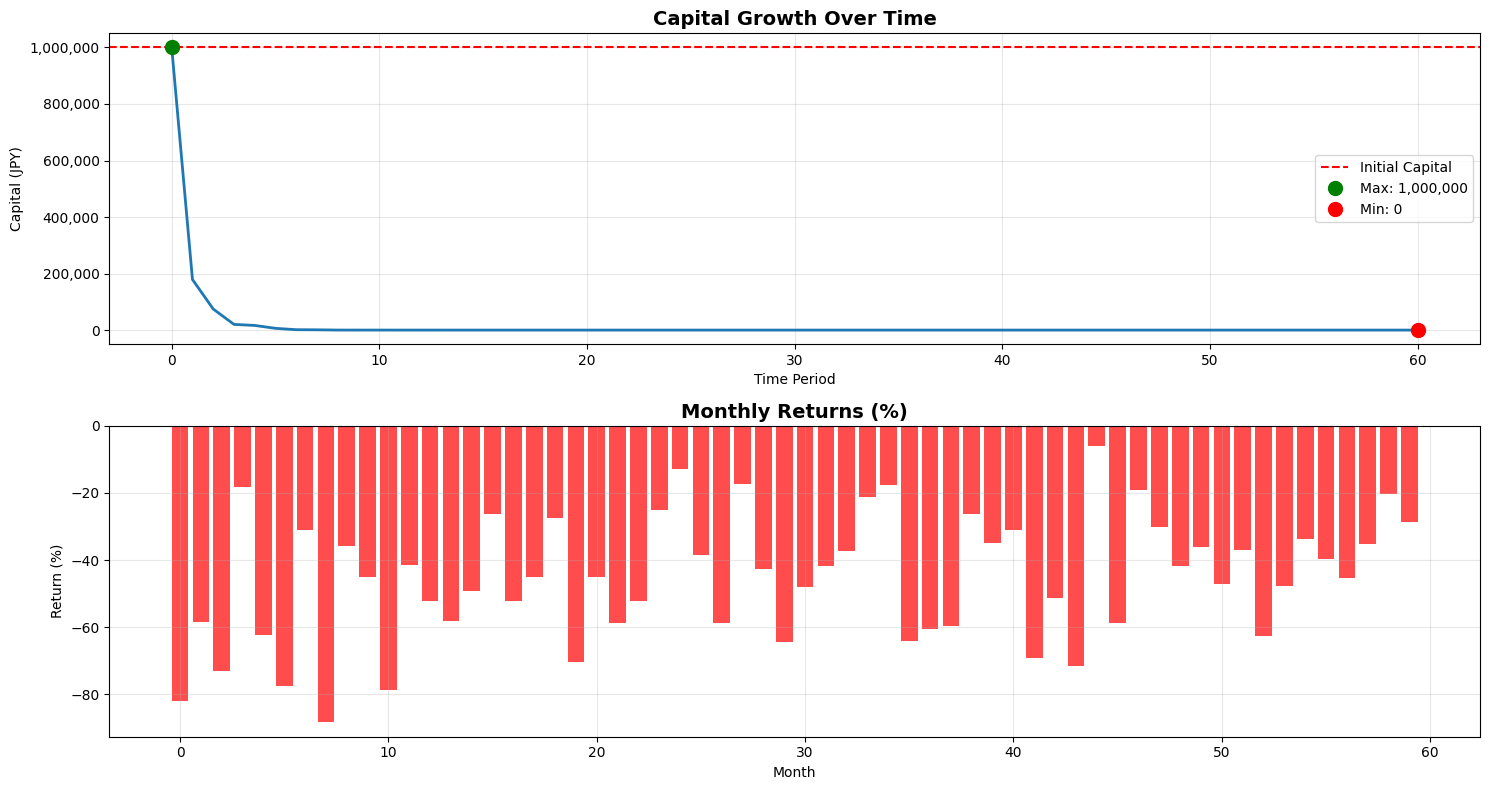


=== Backtest Results ===
Initial Capital: 1,000,000 JPY
Final Capital: 0 JPY
Total Return: -100.00%
Max Drawdown: -100.00%
Total Bets: 13809
Win Rate: 33.12%

Positive Months: 0/60 (0.0%)
Average Monthly Return: -45.17%
Monthly Return Std Dev: 18.60%
Sharpe Ratio (monthly): -2.43


In [29]:
# 資金推移のグラフ
if len(backtest.capital_history) > 1:
    plt.figure(figsize=(15, 8))
    
    # サブプロット1: 資金推移
    plt.subplot(2, 1, 1)
    dates = [backtest.date_history[0]] + backtest.date_history
    plt.plot(range(len(backtest.capital_history)), backtest.capital_history, linewidth=2)
    plt.axhline(y=backtest.initial_capital, color='r', linestyle='--', label='Initial Capital')
    
    # 最高値と最低値をマーク
    max_capital = max(backtest.capital_history)
    min_capital = min(backtest.capital_history)
    max_idx = backtest.capital_history.index(max_capital)
    min_idx = backtest.capital_history.index(min_capital)
    
    plt.plot(max_idx, max_capital, 'go', markersize=10, label=f'Max: {max_capital:,.0f}')
    plt.plot(min_idx, min_capital, 'ro', markersize=10, label=f'Min: {min_capital:,.0f}')
    
    plt.title('Capital Growth Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Time Period')
    plt.ylabel('Capital (JPY)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # y軸を円表記にフォーマット
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # サブプロット2: 月次リターン
    plt.subplot(2, 1, 2)
    monthly_returns = []
    for i in range(1, len(backtest.capital_history)):
        monthly_return = (backtest.capital_history[i] / backtest.capital_history[i-1] - 1) * 100
        monthly_returns.append(monthly_return)
    
    colors = ['green' if r > 0 else 'red' for r in monthly_returns]
    plt.bar(range(len(monthly_returns)), monthly_returns, color=colors, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    plt.title('Monthly Returns (%)', fontsize=14, fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Return (%)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報の表示
    print("\n=== Backtest Results ===")
    print(f"Initial Capital: {backtest.initial_capital:,} JPY")
    print(f"Final Capital: {backtest.capital_history[-1]:,.0f} JPY")
    print(f"Total Return: {(backtest.capital_history[-1]/backtest.initial_capital-1)*100:.2f}%")
    print(f"Max Drawdown: {((min_capital/max_capital-1)*100):.2f}%")
    print(f"Total Bets: {len(backtest.bet_history)}")
    
    # 勝率の計算
    wins = sum(1 for bet in backtest.bet_history if bet['result'] == 1)
    win_rate = (wins / len(backtest.bet_history) * 100) if backtest.bet_history else 0
    print(f"Win Rate: {win_rate:.2f}%")
    
    # 月次統計
    positive_months = sum(1 for r in monthly_returns if r > 0)
    print(f"\nPositive Months: {positive_months}/{len(monthly_returns)} ({positive_months/len(monthly_returns)*100:.1f}%)")
    print(f"Average Monthly Return: {np.mean(monthly_returns):.2f}%")
    print(f"Monthly Return Std Dev: {np.std(monthly_returns):.2f}%")
    print(f"Sharpe Ratio (monthly): {np.mean(monthly_returns)/np.std(monthly_returns) if np.std(monthly_returns) > 0 else 0:.2f}")

## 5. 年別パフォーマンス分析

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found


=== Yearly Performance ===
 Year  Bets  Wins Win Rate
 2020  2750   838    30.5%
 2021  2770   892    32.2%
 2022  2769   953    34.4%
 2023  2778   934    33.6%
 2024  2742   956    34.9%


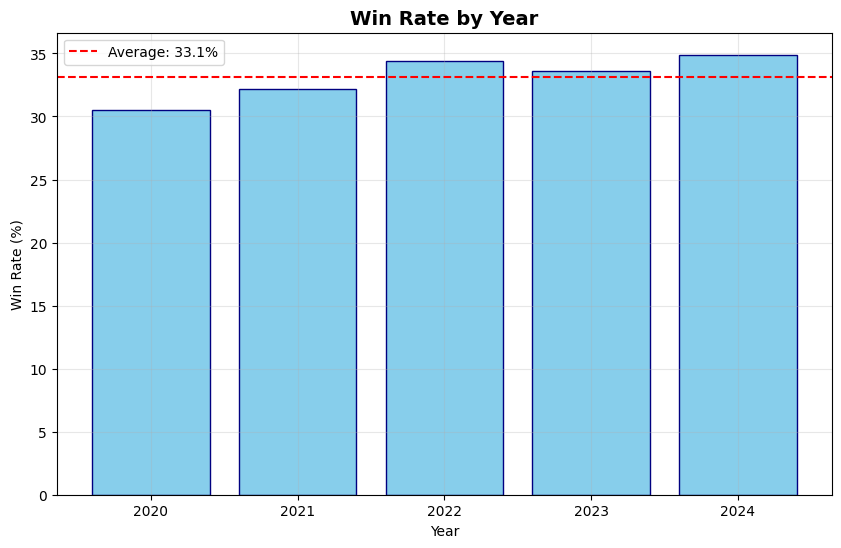

In [30]:
# 年別のパフォーマンスを計算
if len(backtest.bet_history) > 0:
    # 賭けデータをDataFrameに変換
    bets_df = pd.DataFrame(backtest.bet_history)
    
    # race_idから年を抽出（race_idの最初の4文字が年）
    bets_df['year'] = bets_df['race_id'].astype(str).str[:4].astype(int)
    
    # 年別の統計
    yearly_stats = []
    for year in sorted(bets_df['year'].unique()):
        year_bets = bets_df[bets_df['year'] == year]
        wins = (year_bets['result'] == 1).sum()
        total_bets = len(year_bets)
        win_rate = wins / total_bets * 100 if total_bets > 0 else 0
        
        yearly_stats.append({
            'Year': year,
            'Bets': total_bets,
            'Wins': wins,
            'Win Rate': f"{win_rate:.1f}%"
        })
    
    yearly_df = pd.DataFrame(yearly_stats)
    print("\n=== Yearly Performance ===")
    print(yearly_df.to_string(index=False))
    
    # 年別勝率のグラフ
    plt.figure(figsize=(10, 6))
    win_rates = [float(s['Win Rate'].strip('%')) for s in yearly_stats]
    plt.bar(yearly_df['Year'], win_rates, color='skyblue', edgecolor='navy')
    plt.axhline(y=np.mean(win_rates), color='red', linestyle='--', 
                label=f'Average: {np.mean(win_rates):.1f}%')
    plt.title('Win Rate by Year', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Win Rate (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 6. リスク分析

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found

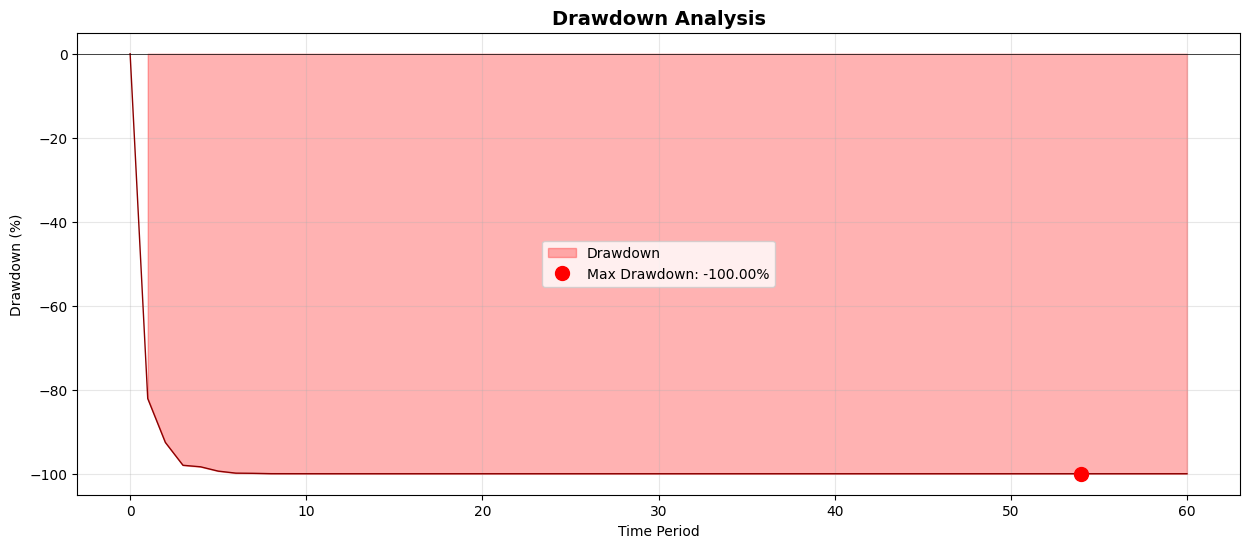


=== Risk Metrics ===
Maximum Drawdown: -100.00%
Average Win: 276 JPY
Average Loss: -245 JPY
Win/Loss Ratio: 1.13
Profit Factor: 0.56


In [31]:
# ドローダウン分析
if len(backtest.capital_history) > 1:
    # ドローダウンの計算
    capital_array = np.array(backtest.capital_history)
    running_max = np.maximum.accumulate(capital_array)
    drawdown = (capital_array - running_max) / running_max * 100
    
    plt.figure(figsize=(15, 6))
    plt.fill_between(range(len(drawdown)), drawdown, 0, 
                     where=(drawdown < 0), color='red', alpha=0.3, label='Drawdown')
    plt.plot(drawdown, color='darkred', linewidth=1)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 最大ドローダウンをマーク
    max_dd_idx = np.argmin(drawdown)
    plt.plot(max_dd_idx, drawdown[max_dd_idx], 'ro', markersize=10, 
             label=f'Max Drawdown: {drawdown[max_dd_idx]:.2f}%')
    
    plt.title('Drawdown Analysis', fontsize=14, fontweight='bold')
    plt.xlabel('Time Period')
    plt.ylabel('Drawdown (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # リスク指標の計算
    returns_array = np.array(backtest.return_history)
    positive_returns = returns_array[returns_array > 0]
    negative_returns = returns_array[returns_array < 0]
    
    print("\n=== Risk Metrics ===")
    print(f"Maximum Drawdown: {drawdown.min():.2f}%")
    print(f"Average Win: {positive_returns.mean() if len(positive_returns) > 0 else 0:,.0f} JPY")
    print(f"Average Loss: {negative_returns.mean() if len(negative_returns) > 0 else 0:,.0f} JPY")
    print(f"Win/Loss Ratio: {abs(positive_returns.mean()/negative_returns.mean()) if len(negative_returns) > 0 and negative_returns.mean() != 0 else 0:.2f}")
    print(f"Profit Factor: {positive_returns.sum()/abs(negative_returns.sum()) if negative_returns.sum() != 0 else 0:.2f}")

## 7. まとめと推奨事項

In [32]:
print("\n=== Summary and Recommendations ===")

if len(backtest.capital_history) > 1:
    final_return = (backtest.capital_history[-1] / backtest.initial_capital - 1) * 100
    
    if final_return > 0:
        print("✅ The strategy showed positive returns over the backtest period.")
    else:
        print("❌ The strategy resulted in losses over the backtest period.")
    
    print("\nKey Findings:")
    print(f"1. Total return: {final_return:.2f}%")
    print(f"2. Win rate: {win_rate:.2f}%")
    print(f"3. Maximum drawdown: {drawdown.min():.2f}%")
    
    print("\nRecommendations:")
    if drawdown.min() < -20:
        print("⚠️  High drawdown detected. Consider:")
        print("   - Reducing bet size")
        print("   - Implementing stop-loss rules")
        print("   - Diversifying betting strategy")
    
    if win_rate < 10:
        print("⚠️  Low win rate detected. Consider:")
        print("   - Improving model features")
        print("   - Adjusting prediction threshold")
        print("   - Focusing on higher probability bets")
    
    print("\n💡 General recommendations:")
    print("1. This is a simplified backtest - real results may differ")
    print("2. Consider transaction costs and slippage")
    print("3. Past performance doesn't guarantee future results")
    print("4. Always bet responsibly within your means")


=== Summary and Recommendations ===
❌ The strategy resulted in losses over the backtest period.

Key Findings:
1. Total return: -100.00%
2. Win rate: 34.87%
3. Maximum drawdown: -100.00%

Recommendations:
⚠️  High drawdown detected. Consider:
   - Reducing bet size
   - Implementing stop-loss rules
   - Diversifying betting strategy

💡 General recommendations:
1. This is a simplified backtest - real results may differ
2. Consider transaction costs and slippage
3. Past performance doesn't guarantee future results
4. Always bet responsibly within your means
